In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os

import numpy as np
import pandas as pd
import sklearn
import torch
import tqdm

import celltrip

os.environ['AWS_PROFILE'] = 'waisman-admin'


# Load Data and Policy

In [3]:
# Load train and validation data
adatas_train = celltrip.utility.processing.read_adatas(
    's3://nkalafut-celltrip/Cortex/brain_st_cortex_expression.h5ad',
    's3://nkalafut-celltrip/Cortex/brain_st_cortex_spatial.h5ad',
    backed=True)
adata_val, = celltrip.utility.processing.read_adatas(
    's3://nkalafut-celltrip/Cortex/brain_sc_expression.h5ad',
    backed=True)
# Model location and name (should contain .weights, .pre, and .mask file)
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Cortex-250919', 800  # On lognorm data from authors
prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Cortex-250922', 800  # Raw data
# Generate or load preprocessing
preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
# Create sample env (kind of a dumb workaround, TODO)
m1, m2 = [preprocessing.transform(ad[:2].X, subset_modality=i)[0] for i, ad in enumerate(adatas_train)]
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), torch.tensor(m2), target_modalities=[1], compute_rewards=False, dim=8).eval().to('cuda')
# Load policy
policy = celltrip.policy.create_agent_from_env(
    env, forward_batch_size=1_000, vision_size=1_000).eval().to('cuda')  # , pinning_spatial=[1]
policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');


# Generate Steady State

In [4]:
# Correct distribution
train_exp = adatas_train[0].X[:]
val_exp = adata_val.X[:]
# Initialize validation environment
m1, = preprocessing.transform(val_exp, subset_modality=0)
# m1, = preprocessing.transform(val_exp_corrected, subset_modality=0)
# Initialize environment and policy
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), target_modalities=None, compute_rewards=False, dim=8).eval(time_scale=1).to('cuda')
# Run policy to convergence
env.reset()
ret = celltrip.train.simulate_until_completion(env, policy, skip_states=100, store_states='cpu', progress_bar=True)
steady_state = ret[-1][-1, :, :env.dim]
# target_state = env.modalities[env.target_modalities[0]].cpu()
with torch.no_grad():
    imputed_steady_state = policy.pinning[0](steady_state.to('cuda')).detach().cpu().numpy()  # , Y=target_state.to('cuda')
imputed_steady_state, = preprocessing.inverse_transform(imputed_steady_state, subset_modality=1)

# Use OT to match distributions
a, b, M_raw, OT_mat = celltrip.utility.general.compute_discrete_ot_matrix(imputed_steady_state, adatas_train[1].X[:])
max_idx = OT_mat.argmax(axis=1)
imputed_steady_state_OT = adatas_train[1].X[:][max_idx]
cost = M_raw[np.arange(M_raw.shape[0]), max_idx]
cost_mask = cost < np.quantile(cost, .5)

# Save
np.save(f'../plots/cortex/CellTRIP_Validation.npy', imputed_steady_state)
np.save(f'../plots/cortex/CellTRIP-OT_Validation.npy', imputed_steady_state_OT)


1281it [00:18, 67.81it/s]


## Preview

<Axes: xlabel='layer', ylabel='subclass'>

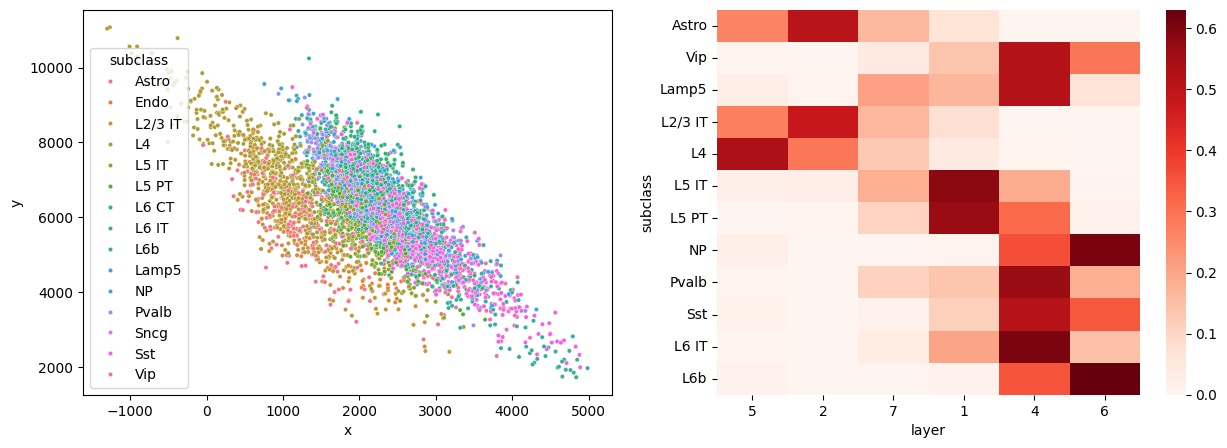

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Construct heatmap
df = pd.DataFrame(index=adata_val.obs.index)
imputed_to_use = imputed_steady_state
# imputed_to_use = imputed_steady_state_OT
df[['x', 'y']] = imputed_to_use
df['subclass'] = adata_val.obs['subclass']
import sklearn.neighbors
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
knn.fit(adatas_train[1].X[:], adatas_train[1].obs['seurat_clusters'])
layers = knn.predict(imputed_to_use)
df['layer'] = layers
# df = df.loc[cost_mask]
pivot_df = (
    df.groupby(['subclass', 'layer'], observed=True).size()
    .reset_index(name='Count')
    .pivot(index='subclass', columns='layer', values='Count'))
pivot_df = pivot_df.fillna(0).div(pivot_df.sum(axis=1), axis=0)

# Scatter
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(df, x='x', y='y', hue='subclass', s=10., ax=axs[0])
# axs[0].set(xlim=[500, 6_000], ylim=[0, 7_000])

# Heatmap
row_order = ['Astro', 'Vip', 'Lamp5', 'L2/3 IT', 'L4', 'L5 IT', 'L5 PT', 'NP', 'Pvalb', 'Sst', 'L6 IT', 'L6b']
col_order = [5, 2, 7, 1, 4, 6]
sns.heatmap(pivot_df.loc[row_order, col_order], cmap='Reds', ax=axs[1])
